In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 20, 10

In [51]:
import pickle
import pandas as pd
import numpy as np

In [52]:
with open("rst.pkl", "rb") as fp:
    rst_lst = pickle.load(fp)

In [53]:
Y_FILE = "./USTREASURY-REALYIELD.csv"

In [54]:
rate_se = pd.read_csv(Y_FILE, index_col=0)["10 YR"]
rate_se.index = pd.DatetimeIndex(y_df.index)
rate_se = rate_se.sort_index()

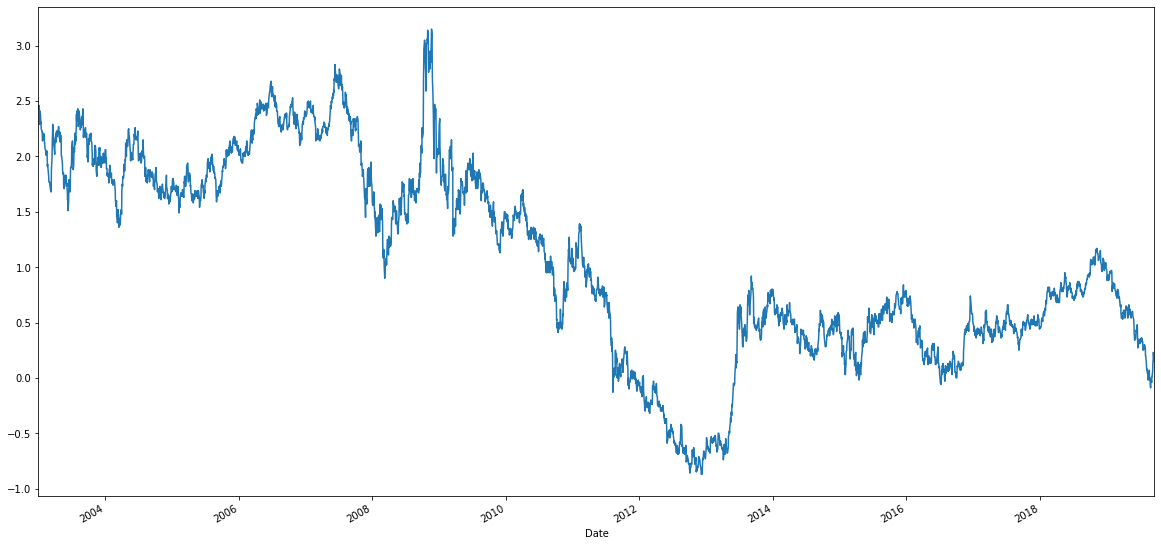

In [55]:
rate_se.plot()

## Overall reval profile 

Reval/preval analysis is a widely used tools in market impact analysis. It is defined as the price movement before and after a certain incident happens in the market. In this case study, we first look at 5-year treasury yield movement before and after the Fed speech as a whole. Then we might want to generate features through the text and then to look at if the reval of differnet groups have diverged profiles.

In [66]:
def get_reval(prev_n=10, rev_n=10):
    y_lst = []

    for ctt in rst_lst:
        prev = rate_se[rate_se.index <= pd.to_datetime(ctt[1])][-prev_n:].values
        rev = rate_se[rate_se.index > pd.to_datetime(ctt[1])][:rev_n].values
        this = prev[-1]
        y_lst.append(np.log(np.hstack((prev, rev)) / this))
    return y_lst

In [67]:
rev_lst = get_reval()

C:\Users\hoore\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\hoore\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
C:\Users\hoore\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\hoore\Miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [74]:
tt = np.vstack(rev_lst)

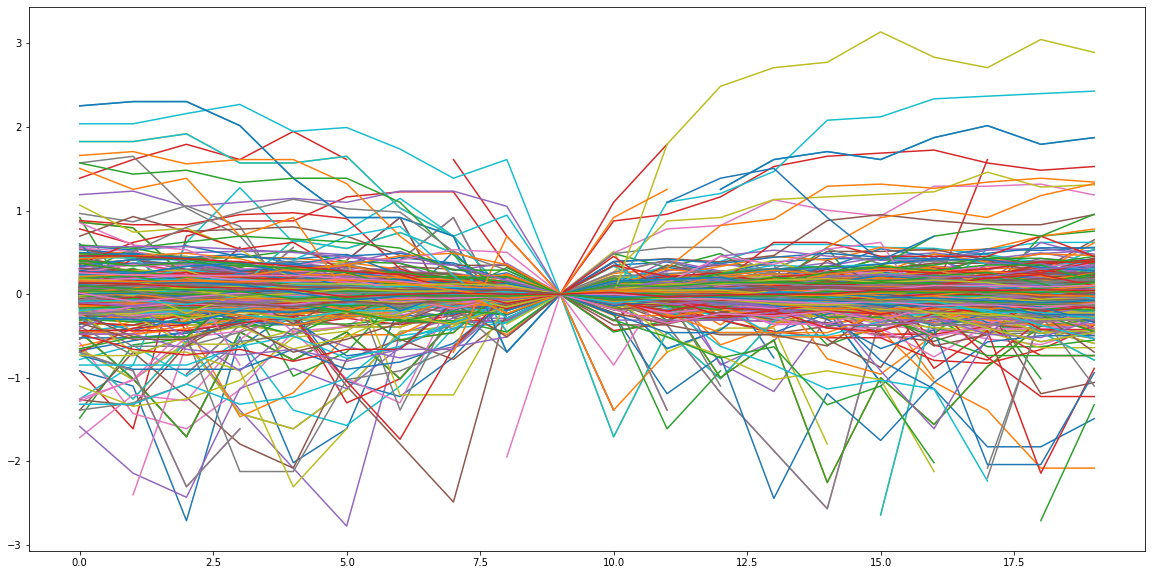

In [77]:
plt.plot(tt.T);

## 1. Generate word bags using similar codes in naive_bayes_classifier

## 2. The reval characterisctic is captured by n day rate movement, we first set n == 1

## 3. Fit a naive bayes model to learn about which word/words could have the most impact of the rate.

## Future work
1. Use title information and treat title worlds differently as those in the body of the article
2. Cross-validation over time
3. Word2Vec